In [1]:
import pandas as pd
import requests, json
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
url = 'http://api.worldbank.org/v2/countries/indicators/SP.POP.TOTL?format=json&date=2007'
req = requests.get(url).text
response = json.loads(req)

In [3]:
response[1][1]

{'indicator': {'id': 'SP.POP.TOTL', 'value': 'Population, total'},
 'country': {'id': 'S3', 'value': 'Caribbean small states'},
 'countryiso3code': 'CSS',
 'date': '2007',
 'value': 6833393,
 'unit': '',
 'obs_status': '',
 'decimal': 0}

In [4]:
def append_response(data, response):
    """ Append a page of an api call to the world bank for an indicator.
        input: 
        * data: list with values from previous pages.
        * response: loaded json response from a call to the world bank api.
        output:
        * data: input data with appended data from the response.
    """
    items = response[1]
    for item in items:
        # country, year, value
        data.append([item['country']['value'], item['date'], item['value']])
    return data

def get_world_data_indicator(url):
    """ Get all the values for an indicator call of the world bank api. The url shouldn't include 
        the page argument and must indicate the format to be json.
    """
    req = requests.get(url).text
    response = json.loads(req)
    num_pages = response[0]['pages']
    name = response[1][1]['indicator']['value']
    # Get the first page of data
    data = append_response([], response)
    # Get data of all the other pages.
    for page in range(2, num_pages+1):
        page_url = url + '&page={}'.format(page)
        req = requests.get(page_url).text
        response = json.loads(req)
        data = append_response(data, response)
    return name, data

In [5]:
# Urls to get the data for all countries for 2016 using the worldbank's api. 
urls = {'gdp': 'http://api.worldbank.org/v2/countries/indicators/NY.GDP.MKTP.CD?format=json&date=2016',
        'population': 'http://api.worldbank.org/v2/countries/indicators/SP.POP.TOTL?format=json&date=2016',
        'health_expenditure_per_capita': 'http://api.worldbank.org/v2/countries/indicators/SH.XPD.CHEX.PC.CD?format=json&date=2016',
        'life_expectancy': 'http://api.worldbank.org/v2/countries/indicators/SP.DYN.LE00.IN?format=json&date=2016',
       }

# Name of data points which are not countries. So we can distinguish them.
regions = ['Arab World', 'Caribbean small states','Central Europe and the Baltics', 'Early-demographic dividend',
        'East Asia & Pacific', 'East Asia & Pacific (excluding high income)','East Asia & Pacific (IDA & IBRD countries)',
        'Euro area','Europe & Central Asia','Europe & Central Asia (excluding high income)',
        'Europe & Central Asia (IDA & IBRD countries)', 'European Union', 'Fragile and conflict affected situations',
        'Heavily indebted poor countries (HIPC)', 'High income', 'IBRD only','IDA & IBRD total', 'IDA blend',
        'IDA only', 'IDA total', 'Late-demographic dividend', 'Latin America & Caribbean',
        'Latin America & Caribbean (excluding high income)', 'Latin America & the Caribbean (IDA & IBRD countries)',
        'Least developed countries: UN classification', 'Low & middle income', 'Low income', 'Lower middle income',
        'Middle East & North Africa', 'Middle East & North Africa (excluding high income)',
        'Middle East & North Africa (IDA & IBRD countries)', 'Middle income', 'North America', 'OECD members',
        'Other small states', 'Pacific island small states', 'Post-demographic dividend',
        'Pre-demographic dividend', 'Small states', 'South Asia', 'South Asia (IDA & IBRD)', 'Sub-Saharan Africa',
        'Sub-Saharan Africa (excluding high income)', 'Sub-Saharan Africa (IDA & IBRD countries)',
        'Upper middle income', 'World', 'Not classified']

# Some countries are called different by the world bank and our file with continents.
# Note that this is not extensive, I have probably missed more than a few.
rename_countries = {
    'Bahamas': 'Bahamas, The', 'Brunei': 'Brunei Darussalam', 'CZ': 'Czech Republic', 'Cape Verde': 'Cabo Verde',
    'Congo': 'Congo, Rep.', 'Congo, Democratic Republic of': 'Congo, Dem. Rep.', 'East Timor': 'Timor-Leste',
    'Egypt': 'Egypt, Arab Rep.', 'Gambia': 'Gambia, The', 'Iran': 'Iran, Islamic Rep.',
    'Ivory Coast': "Cote d'Ivoire", 'Korea, South': 'Korea, Rep.', 'Korea, North': 'Korea, Dem. People’s Rep',
    'Kyrgyzstan': 'Kyrgyz Republic','Laos': 'Lao PDR', 'Macedonia': 'North Macedonia',
    'Micronesia': 'Micronesia, Fed. Sts.', 'Saint Lucia': 'St. Lucia',
    'Saint Vincent and the Grenadines': 'St. Vincent and the Grenadines', 'Slovakia': 'Slovak Republic',
    'Swaziland': 'Eswatini', 'US': 'United States', 'Burina': 'Burkina Faso', 'Burma (Myanmar)': 'Myanmar',
    'Yemen': 'Yemen, Rep.',
}

In [6]:
keys = list(urls.keys())

key = keys[0]
_, data = get_world_data_indicator(urls[key])
df = pd.DataFrame(data, columns=['country','year', key]).set_index('country')

for key in keys[1:]:
    _, data = get_world_data_indicator(urls[key])
    data = pd.DataFrame(data, columns=['country','year','value']).set_index('country')
    df[key] = data['value']

# Drop values that are not countries.
df.drop(regions, axis='rows', inplace=True)

df['gdp_per_capita'] = df['gdp']/df['population']

# Add continent information:
continents_df = pd.read_csv('Countries-Continents.csv')
continents_df.columns = ['continent','country']
continents_df.set_index('country', inplace=True)
continents_df.rename(index=rename_countries, inplace=True)

df['continent'] = continents_df['continent']

df.head()

,year,gdp,population,health_expenditure_per_capita,life_expectancy,gdp_per_capita,continent
country,,,,,,,
Afghanistan,2016,1.936264e+10,35383128.0,61.451286,63.763,547.228110,Asia
Albania,2016,1.186120e+10,2876101.0,NaN,78.194,4124.055726,Europe
Algeria,2016,1.600338e+11,40551404.0,260.422394,76.298,3946.443977,Africa
American Samoa,2016,6.520000e+08,55741.0,NaN,NaN,11696.955562,NaN
Andorra,2016,2.896679e+09,77297.0,3843.702881,NaN,37474.665406,Europe


In [7]:
df.loc[['Spain','United Kingdom','France','Germany','China','United States']]

,year,gdp,population,health_expenditure_per_capita,life_expectancy,gdp_per_capita,continent
country,,,,,,,
Spain,2016,1.232076e+12,4.648406e+07,2390.631104,83.329268,26505.343216,Europe
United Kingdom,2016,2.694283e+12,6.561159e+07,3945.009033,81.156098,41064.133432,Europe
France,2016,2.471286e+12,6.672410e+07,4256.961426,82.573171,37037.374186,Europe
Germany,2016,3.466790e+12,8.234867e+07,4734.183105,80.990244,42098.920445,Europe
China,2016,1.123328e+13,1.378665e+09,398.331573,76.210000,8147.938148,Asia
United States,2016,1.870719e+13,3.229413e+08,9941.347656,78.539024,57927.516852,North America


In [8]:
df.sort_values('gdp_per_capita', ascending=False).head(10)

,year,gdp,population,health_expenditure_per_capita,life_expectancy,gdp_per_capita,continent
country,,,,,,,
Monaco,2016,6.472991e+09,38070.0,2938.534424,NaN,170028.655718,Europe
Liechtenstein,2016,6.237264e+09,37658.0,NaN,82.258537,165629.190483,Europe
Luxembourg,2016,6.069148e+10,582014.0,5595.554199,82.685366,104278.390972,Europe
Switzerland,2016,6.713092e+11,8373338.0,9835.963867,83.602439,80172.232075,Europe
Isle of Man,2016,6.592628e+09,83287.0,NaN,NaN,79155.541672,NaN
Cayman Islands,2016,4.898909e+09,62569.0,NaN,NaN,78296.099927,NaN
"Macao SAR, China",2016,4.538730e+10,612836.0,NaN,83.854000,74061.086035,NaN
Norway,2016,3.688199e+11,5234519.0,7496.768555,82.407317,70459.182504,Europe
Ireland,2016,3.005233e+11,4755335.0,4721.105469,81.653659,63197.082374,Europe


In [9]:
df.to_csv('health_spending_dataset.csv')

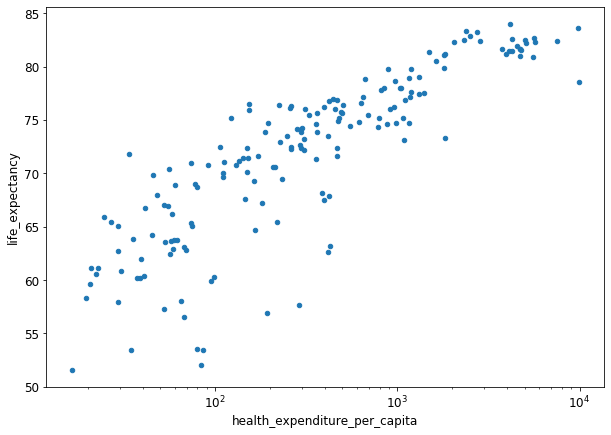

In [10]:
plt.rcParams.update({'font.size': 12})

df.plot.scatter(y='life_expectancy', x='health_expenditure_per_capita', figsize=(10,7))
plt.xscale('log')
plt.show()

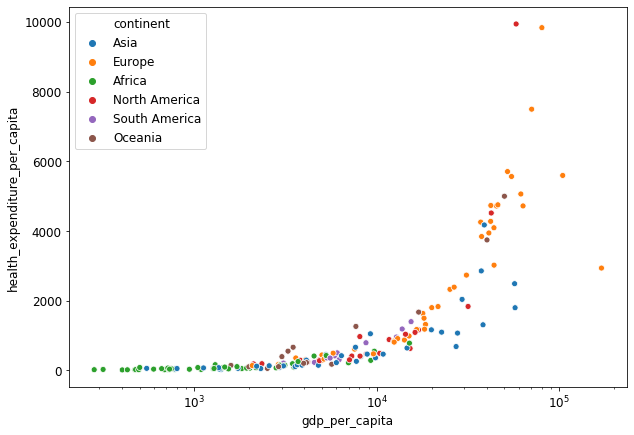

In [11]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(10,7))
sns.scatterplot(x='gdp_per_capita', y='health_expenditure_per_capita', hue='continent', data=df, ax=ax)
plt.xscale('log')
plt.show()

## Missing values ##

In [12]:
total = df['population'].sum()
print('World ({} countries) population in 2016 according to world bank: {:.0f}'\
      ' million people'.format(len(df), total/1e6))

x = df.loc[df['continent'].isnull(),'population']
print('Population of {} countries with null continent: {:.0f} million people (which is {:.2f}% of the total world population)'
      .format(x.count(), x.sum()/1e6, x.sum()/total*100))

x = df.loc[df.isna().any(axis=1),'population']
print('Population of {} countries with some null value: {:.0f} (which is {:.2f}% of the total world population)'
      .format(x.count(), x.sum()/1e6,  x.sum()/total*100))


World (217 countries) population in 2016 according to world bank: 7397 million people
Population of 29 countries with null continent: 111 million people (which is 1.50% of the total world population)
Population of 44 countries with some null value: 173 (which is 2.34% of the total world population)


In [13]:
df.loc[df['continent'].isnull()]

,year,gdp,population,health_expenditure_per_capita,life_expectancy,gdp_per_capita,continent
country,,,,,,,
American Samoa,2016,6.520000e+08,55741.0,NaN,NaN,11696.955562,NaN
Aruba,2016,2.965922e+09,104872.0,NaN,75.868000,28281.350482,NaN
Bermuda,2016,NaN,64554.0,NaN,81.227073,NaN,NaN
British Virgin Islands,2016,NaN,29355.0,NaN,NaN,NaN,NaN
Burkina Faso,2016,1.282256e+10,18646378.0,40.954662,60.354000,687.670175,NaN
Cayman Islands,2016,4.898909e+09,62569.0,NaN,NaN,78296.099927,NaN
Channel Islands,2016,NaN,166923.0,NaN,82.600000,NaN,NaN
Curacao,2016,3.122288e+09,159664.0,NaN,77.719512,19555.365849,NaN
Faroe Islands,2016,2.689157e+09,48173.0,NaN,82.046341,55822.914720,NaN


It seems like a lot of the countries missing the continent, are also missing values on other columns. I think this is probably because it is harder to obtain information for countries that are particularly small, or which have complicated politics/territorial disputes. This same countries are the ones which are more likely to be named differently on different datasets or be missed by the datasets I use for the continents.